# Beautiful Soup
Biblioteka do Pythona.
https://www.crummy.com/software/BeautifulSoup/bs4/doc/

In [4]:
import json
import re
import pandas as pd
import urllib
from urllib.request import Request
from bs4 import BeautifulSoup

Pobieramy html z zegluj.pl i wstępnie procesujemy przez Beautiful Soup.

Trzeba sprawdzić ile jest stron w wynikach, można to napisać ładnie, żeby samo się analizowało, na podstawie klasy disabled (lub jej braku) na elemencie następna strona.

In [6]:
url = "https://zegluj.pl/mazury?date_from=01-05-2025&date_to=07-05-2025&page="

pages = []
for page_number in range(1, 18):
    print(f'Pobieranie strony {page_number}')
    with urllib.request.urlopen(f'{url}{page_number}') as resp:
        processed_page = BeautifulSoup(resp.read().decode('utf-8'), "html.parser")
        pages.append(processed_page)


Pobieranie strony 1
Pobieranie strony 2
Pobieranie strony 3
Pobieranie strony 4
Pobieranie strony 5
Pobieranie strony 6
Pobieranie strony 7
Pobieranie strony 8
Pobieranie strony 9
Pobieranie strony 10
Pobieranie strony 11
Pobieranie strony 12
Pobieranie strony 13
Pobieranie strony 14
Pobieranie strony 15
Pobieranie strony 16
Pobieranie strony 17


In [7]:
pages[3]

<!DOCTYPE html>

<html lang="pl" xmlns="http://www.w3.org/1999/xhtml">
<head>
<title>⚓ Czarter jachtów Mazury 2025. Wynajem jachtów na Mazurach - zegluj.pl</title>
<meta content="Czarter jachtów Mazury - 2025. Jachty motorowe, houseboaty oraz żaglówki do czarteru na Mazurach. Porównaj ofertę 130 firm czarterowych, wybierz najlepszą ofertę. Na zegluj.pl znajdziesz najlepsze ceny czarterów oraz oferty last minute. Mazurskie jeziora" name="description"/>
<meta content="czarter, mazury" name="keywords"/>
<meta content="index, follow" name="robots"/>
<link href="https://zegluj.pl/mazury" rel="canonical"/>
<meta content="zegluj.pl | czartery jachtów. Porównaj oferty firm czarterowych. Rabaty do 30%." property="og:title"/>
<meta content="/assets/fb_zegluj-b6311e80fada9f469076f632f87ee111.jpg" property="og:image"/>
<meta content="Proste wyszukiwanie, szybka rezerwacja, intuicyjne określenie wolnych terminów, tylko dostępne oferty. Nowa jakość i wielkość oferty. Kochasz żeglarstwo? Znajdź coś d

Wyciągamy poszczególne boksy z łódkami




In [9]:
full_yacht_data = []
for page in pages:

    full_yacht_data += page.find_all(class_='yacht-box')

In [10]:
full_yacht_data

[<div class="yacht-box">
 <div class="row">
 <div class="col-md-4 yacht-box__column yacht-box__column--overflowed">
 <div class="yacht-box__badge badge badge--positive">
 Bez patentu
 </div>
 <div class="yacht-box__image">
 <a href="/jacht/sasanka-600-viva/229#/avail/date_from=01-05-2025/date_to=07-05-2025/"><img alt="Mazury czarter - Sasanka 600 Viva" src="/system/yacht_cms_images/images/000/019/632/medium/sasanka-600-viva-1676896816.jpg?1676896815"/>
 </a><div class="yacht-box__location">
 <blockquote>Rydzewo, port Tło dla Mew</blockquote>
 </div>
 </div>
 </div>
 <div class="col-md-8 yacht-box__column">
 <div class="yacht-box__content">
 <div class="row">
 <div class="col-sm-7 yacht-box-content__left">
 <div class="yacht-box__title">
 <h3 class="yacht-box__name">
 Sasanka 600 Viva
 </h3>
 <div class="yacht-box__votescounter">
 <div id="details_more_info"></div>
 <a class="yacht-box__votes" href="/jacht/sasanka-600-viva/229/yacht_reviews#/avail/date_from=01-05-2025/date_to=07-05-2025

Analizujemy dane i przygotowujemy słownik z danymi

### Tester dla jednego jachtu (krótszy czas obliczeń)

In [29]:
yacht_html = full_yacht_data[0]

yacht = {}
yacht['name'] = yacht_html.find(class_="yacht-box__name").text.strip()
yacht['price'] = float(yacht_html.find(class_="price right").span.contents[0].replace(' ', '').replace('zł', '').replace('PLN', ''))
yacht['img'] = f"https://zegluj.pl{yacht_html.img['src']}"
yacht['url'] = f"https://zegluj.pl{yacht_html.find(class_='yacht-box__image').a['href']}"
# parameters
for param_row in yacht_html.select('li.yacht-box-info__item'):
    param_data = param_row.find_all('div')
    param_type = param_data[0].text.strip()
    param_value = re.sub(r'\s+', '', param_data[1].text.strip())
    if 'osób' in param_type:
        #yacht['people'] = param_value
        try:
          yacht['people'] = int(param_value.split('-')[-1])
        except ValueError:
          yacht['people'] = None
    elif 'kabin' in param_type:
        try:
            yacht['cabins'] = int(param_value.split('-')[-1])
        except ValueError:
            yacht['cabins'] = None
        # yacht['cabins'] = int(param_value)
    elif 'produkcji' in param_type:
        yacht['year'] = param_value

#scraping data from 'description' subpage
print(yacht)
print('Po scrapowaniu podstrony:')
with urllib.request.urlopen(yacht['url']) as resp:
    subpage = BeautifulSoup(resp.read().decode('utf-8'), "html.parser")
    
for div in subpage.find_all("div"):
    if "form-row" in div.get("class", []) or "footer-top-nav__col" in div.get("class", []) or "yacht-details__location" in div.get("class", []):
        continue
    if div.find(itemprop=["name", "category"]):
        continue
    text = div.get_text(strip=True, separator=": ").split(": ")
    if len(text) == 2:
        key, value = text
        key=key.replace(":","").lower()
        if key == 'więcej zdjęć':
            continue
        if key == 'liczba osób' or key =='łazienki' or key=='zbiornik paliwa' or key == 'zbiornik wody pitnej':
            try:
                value = int(value)
                yacht[key] = value
            except ValueError:
                yacht[key] = None
        if key == 'kaucja' or key == 'opłata za sprzątanie/serwis':
            value = int(value.replace(" ", "").replace("PLN", "").strip())
            try:
                yacht[key]=value
            except ValueError:
                yacht[key] = None
        if key == 'przeciętne spalanie':
            try:
                yacht[key]=float(value)
            except ValueError:
                yacht[key] = None
        else:
            yacht[key] = value 

print(yacht) 

{'name': 'Sasanka 600 Viva', 'price': 1215.0, 'img': 'https://zegluj.pl/system/yacht_cms_images/images/000/019/632/medium/sasanka-600-viva-1676896816.jpg?1676896815', 'url': 'https://zegluj.pl/jacht/sasanka-600-viva/229#/avail/date_from=01-05-2025/date_to=07-05-2025/', 'people': 4, 'cabins': 0, 'year': '2020'}
Po scrapowaniu podstrony:
{'name': 'Sasanka 600 Viva', 'price': 1215.0, 'img': 'https://zegluj.pl/system/yacht_cms_images/images/000/019/632/medium/sasanka-600-viva-1676896816.jpg?1676896815', 'url': 'https://zegluj.pl/jacht/sasanka-600-viva/229#/avail/date_from=01-05-2025/date_to=07-05-2025/', 'people': 4, 'cabins': 0, 'year': '2020', 'liczba osób': 4, 'liczba koi': '4 (3+1)', 'łazienki': 1, 'rok produkcji': '2020', 'uprawnienia': 'Bez patentu', 'kaucja': 1500, 'opłata za sprzątanie/serwis': 170, 'przyjazd': 'od godz.\n17:00', 'wyjazd': 'do godz.\n11:00', 'długość (cm)': '620', 'szerokość (cm)': '245', 'zanurzenie min (cm)': '30', 'zanurzenie max (cm)': '130', 'max wysokość w ka

In [31]:
numeric_values = {key: value for key, value in yacht.items() if isinstance(value, (int, float))}

print(numeric_values)

{'price': 1215.0, 'people': 4, 'cabins': 0, 'liczba osób': 4, 'łazienki': 1, 'kaucja': 1500, 'opłata za sprzątanie/serwis': 170, 'przeciętne spalanie': 1.0, 'zbiornik paliwa': 15, 'zbiornik wody pitnej': 30}


In [40]:
#test subpages
print(subpage)

<!DOCTYPE html>

<html lang="pl" xmlns="http://www.w3.org/1999/xhtml">
<head>
<title>⚓ Czarter jachtu Sasanka 600 Viva - zegluj.pl</title>
<meta content="Czarter jachtu Sasanka 600 Viva - port Tło dla Mew. Rezerwacja online z Gwarancją najniższej ceny." name="description"/>
<meta content="czarter, jachty żaglowe, łodzie motorowe, barki, wynajem, mazury, bałtyk, last minute, mikołajki, giżycko" name="keywords"/>
<meta content="index, follow" name="robots"/>
<link href="https://zegluj.pl/jacht/sasanka-600-viva/229" rel="canonical"/>
<meta content="Czarter jachtu Sasanka 600 Viva" property="og:title"/>
<meta content="https://zegluj.pl/system/yacht_cms_images/images/000/019/632/medium/sasanka-600-viva-1676896816.jpg?1676896815" property="og:image"/>
<meta content="https://zegluj.pl/assets/fb_zegluj-b6311e80fada9f469076f632f87ee111.jpg" property="og:image"/>
<meta content="Czarter jachtu Sasanka 600 Viva - port Tło dla Mew. Rezerwacja online z Gwarancją najniższej ceny." property="og:descri

In [36]:
yachts_data = []
subpages=[]
yacht_num = 0
for yacht_html in full_yacht_data:
    yacht = {}
    yacht['name'] = yacht_html.find(class_="yacht-box__name").text.strip()
    yacht['price'] = float(yacht_html.find(class_="price right").span.contents[0].replace(' ', '').replace('zł', '').replace('PLN', ''))
    yacht['img'] = f"https://zegluj.pl{yacht_html.img['src']}"
    yacht['url'] = f"https://zegluj.pl{yacht_html.find(class_='yacht-box__image').a['href']}"
    # parameters
    for param_row in yacht_html.select('li.yacht-box-info__item'):
        param_data = param_row.find_all('div')
        param_type = param_data[0].text.strip()
        param_value = re.sub(r'\s+', '', param_data[1].text.strip())
        if 'osób' in param_type:
            #yacht['people'] = param_value
            try:
              yacht['people'] = int(param_value.split('-')[-1])
            except ValueError:
              yacht['people'] = None
        elif 'kabin' in param_type:
            try:
                yacht['cabins'] = int(param_value.split('-')[-1])
            except ValueError:
                yacht['cabins'] = None
            # yacht['cabins'] = int(param_value)
        elif 'produkcji' in param_type:
            yacht['year'] = param_value

    #scraping data from 'description' pages
    with urllib.request.urlopen(yacht['url']) as resp:
        subpage = BeautifulSoup(resp.read().decode('utf-8'), "html.parser")
        subpages.append(subpage)
        
    for div in subpage.find_all("div"):
        if "form-row" in div.get("class", []) or "footer-top-nav__col" in div.get("class", []) or "yacht-details__location" in div.get("class", []):
            continue
        if div.find(itemprop=["name", "category"]):
            continue
        text = div.get_text(strip=True, separator=": ").split(": ")
        if len(text) == 2:
            key, value = text
            key=key.replace(":","").lower()
            if key == 'więcej zdjęć':
                continue
            if key == 'liczba osób' or key =='łazienki' or key=='zbiornik paliwa' or key == 'zbiornik wody pitnej':
                try:
                    value = int(value)
                    yacht[key] = value
                except ValueError:
                    yacht[key] = None
            if key == 'kaucja' or key == 'opłata za sprzątanie/serwis':
                value = int(value.replace(" ", "").replace("PLN", "").strip())
                try:
                    yacht[key]=value
                except ValueError:
                    yacht[key] = None
            if key == 'przeciętne spalanie':
                try:
                    yacht[key]=float(value)
                except ValueError:
                    yacht[key] = None
            else:
                yacht[key] = value 
    yacht_num+=1
    print('Przetworzono', yacht_num)
    yachts_data.append(yacht)

Przetworzono 1
Przetworzono 2
Przetworzono 3
Przetworzono 4
Przetworzono 5
Przetworzono 6
Przetworzono 7
Przetworzono 8
Przetworzono 9
Przetworzono 10
Przetworzono 11
Przetworzono 12
Przetworzono 13
Przetworzono 14
Przetworzono 15
Przetworzono 16
Przetworzono 17
Przetworzono 18
Przetworzono 19
Przetworzono 20
Przetworzono 21
Przetworzono 22
Przetworzono 23
Przetworzono 24
Przetworzono 25
Przetworzono 26
Przetworzono 27
Przetworzono 28
Przetworzono 29
Przetworzono 30
Przetworzono 31
Przetworzono 32
Przetworzono 33
Przetworzono 34
Przetworzono 35
Przetworzono 36
Przetworzono 37
Przetworzono 38
Przetworzono 39
Przetworzono 40
Przetworzono 41
Przetworzono 42
Przetworzono 43
Przetworzono 44
Przetworzono 45
Przetworzono 46
Przetworzono 47
Przetworzono 48
Przetworzono 49
Przetworzono 50
Przetworzono 51
Przetworzono 52
Przetworzono 53
Przetworzono 54
Przetworzono 55
Przetworzono 56
Przetworzono 57
Przetworzono 58
Przetworzono 59
Przetworzono 60
Przetworzono 61
Przetworzono 62
Przetworzono 63
P

In [38]:
yachts_data

[{'name': 'Sasanka 600 Viva',
  'price': 1215.0,
  'img': 'https://zegluj.pl/system/yacht_cms_images/images/000/019/632/medium/sasanka-600-viva-1676896816.jpg?1676896815',
  'url': 'https://zegluj.pl/jacht/sasanka-600-viva/229#/avail/date_from=01-05-2025/date_to=07-05-2025/',
  'people': 4,
  'cabins': 0,
  'year': '2020',
  'liczba osób': 4,
  'liczba koi': '4 (3+1)',
  'łazienki': 1,
  'rok produkcji': '2020',
  'uprawnienia': 'Bez patentu',
  'kaucja': 1500,
  'opłata za sprzątanie/serwis': 170,
  'przyjazd': 'od godz.\n17:00',
  'wyjazd': 'do godz.\n11:00',
  'długość (cm)': '620',
  'szerokość (cm)': '245',
  'zanurzenie min (cm)': '30',
  'zanurzenie max (cm)': '130',
  'max wysokość w kabinie (cm)': '155',
  'powierzchnia żagli (m2)': '20',
  'max liczba załogi (bez noclegu)': '4',
  'liczba zamykanych kabin (sypialni)': '0',
  'liczba łazienek': '1',
  'moc silnika': '4',
  'przeciętne spalanie': 1.0,
  'zbiornik paliwa': 15,
  'zbiornik wody pitnej': 30,
  'typ miecza': 'obrot

Możemy dalej analizować pozyskane dane.

Pozbywam się kolumn ze zbyt dużą ilością brakujących danych

In [224]:
df = pd.DataFrame.from_dict(yachts_data)
df['cabins'].fillna(0, inplace=True)
threshold = 0.3 * len(df)
df = df.dropna(axis=1, thresh=threshold)
df.head(5)

,name,price,img,url,people,cabins,year,liczba osób,liczba koi,łazienki,...,przeciętne spalanie,zbiornik paliwa,zbiornik wody pitnej,typ miecza,typ steru,liczba koi (układ koi),typ silnika,rodzaj paliwa,polityka paliwowa,zamykane kabiny
0,Sasanka 600 Viva,1215.0,https://zegluj.pl/system/yacht_cms_images/imag...,https://zegluj.pl/jacht/sasanka-600-viva/229#/...,4,0,2020,4,4 (3+1),1.0,...,1.0,15.0,30.0,obrotowy,ster na pawęży + rumpel,4 (3+1),silnik zaburtowy,benzyna,NaN,NaN
1,Sasanka 660,1215.0,https://zegluj.pl/system/yacht_cms_images/imag...,https://zegluj.pl/jacht/sasanka-660/2329#/avai...,6,0,2012,6,5 (3+2),1.0,...,1.0,15.0,20.0,obrotowy,ster na pawęży + rumpel,5 (3+2),silnik zaburtowy,benzyna,<ul><li>pełny do pełnego - jeśli zabraknie w z...,NaN
2,Sasanka 600 Viva,1215.0,https://zegluj.pl/system/yacht_cms_images/imag...,https://zegluj.pl/jacht/sasanka-600-viva/230#/...,4,0,2020,4,4 (3+1),1.0,...,1.0,15.0,30.0,obrotowy,ster na pawęży + rumpel,4 (3+1),silnik zaburtowy,benzyna,NaN,NaN
3,Laguna 25 (730),1500.0,https://zegluj.pl/system/yacht_cms_images/imag...,https://zegluj.pl/jacht/laguna-25-730/1203#/av...,8,0,2009,8,NaN,1.0,...,NaN,NaN,NaN,obrotowy,Brak danych,NaN,NaN,NaN,NaN,NaN
4,Joker 785,1500.0,https://zegluj.pl/system/yacht_cms_images/imag...,https://zegluj.pl/jacht/joker-785/1202#/avail/...,8,0,2007,8,8 (6+2),1.0,...,NaN,NaN,NaN,obrotowy,Brak danych,8 (6+2),silnik zaburtowy,benzyna,NaN,NaN


array([[<Axes: title={'center': 'price'}>]], dtype=object)

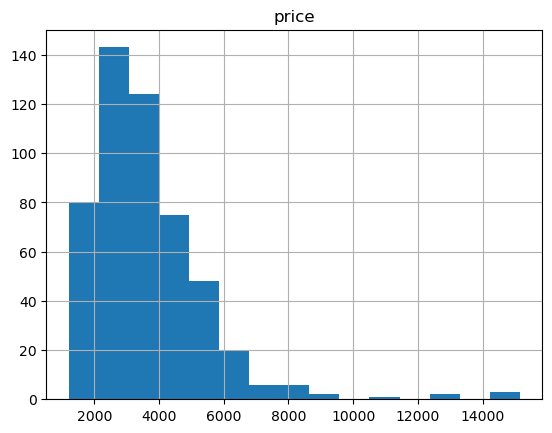

In [64]:
df.hist(column='price', bins=15)

In [66]:
df[ df.price > 10000 ] # 100_000

,name,price,img,url,people,cabins,year,liczba osób,liczba koi,łazienki,...,liczba łazienek,moc silnika,zbiornik paliwa,zbiornik wody pitnej,typ miecza,typ steru,liczba koi (układ koi),typ silnika,rodzaj paliwa,zamykane kabiny
259,Merry Fisher 795 S2,10560.0,https://zegluj.pl/system/yacht_cms_images/imag...,https://zegluj.pl/jacht/merry-fisher-795-s2/13...,9,1,2022,9,4 (2+2),1.0,...,1,150,300.0,70.0,Brak danych,Brak danych,4 (2+2),silnik zaburtowy,benzyna,1
260,Bayliner Ciera,12600.0,https://zegluj.pl/system/yacht_cms_images/imag...,https://zegluj.pl/jacht/bayliner-ciera/2410#/a...,6,1,2022,6,4 (2+2),1.0,...,1,350,265.0,75.0,NaN,NaN,4 (2+2),silnik stacjonarny,olej napędowy,1
261,Seamaster 45,13200.0,https://zegluj.pl/system/yacht_cms_images/imag...,https://zegluj.pl/jacht/seamaster-45/1478#/ava...,10,3,2022,10,8 (6+2),3.0,...,3,80,200.0,300.0,Brak danych,Brak danych,8 (6+2),silnik stacjonarny,olej napędowy,3
262,Maestro 42,14850.0,https://zegluj.pl/system/yacht_cms_images/imag...,https://zegluj.pl/jacht/maestro-42/1681#/avail...,8,3,2023,8,7 (6+1),3.0,...,3,80,270.0,300.0,Brak danych,Brak danych,7 (6+1),silnik stacjonarny,olej napędowy,3
263,Maestro 42,14850.0,https://zegluj.pl/system/yacht_cms_images/imag...,https://zegluj.pl/jacht/maestro-42/1928#/avail...,8,3,2024,8,7 (6+1),3.0,...,3,80,270.0,300.0,Brak danych,Brak danych,7 (6+1),silnik stacjonarny,olej napędowy,3
264,Seamaster 45,15150.0,https://zegluj.pl/system/yacht_cms_images/imag...,https://zegluj.pl/jacht/seamaster-45/816#/avai...,10,4,2021,10,8 (6+2),4.0,...,4,NaN,NaN,NaN,Brak danych,Brak danych,8 (6+2),silnik stacjonarny,NaN,4


array([[<Axes: title={'center': 'price'}>]], dtype=object)

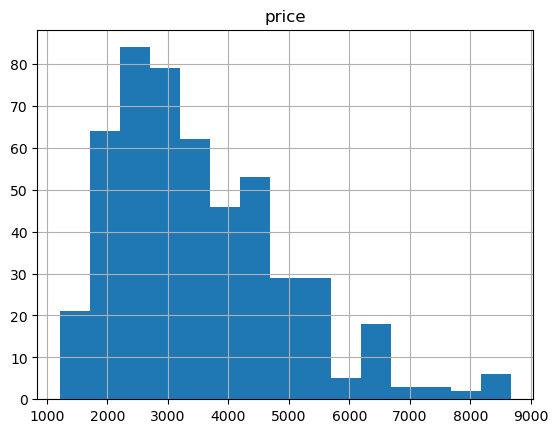

In [68]:
df[ df.price <= 10000 ].hist(column='price', bins=15)

array([[<Axes: title={'center': 'people'}>]], dtype=object)

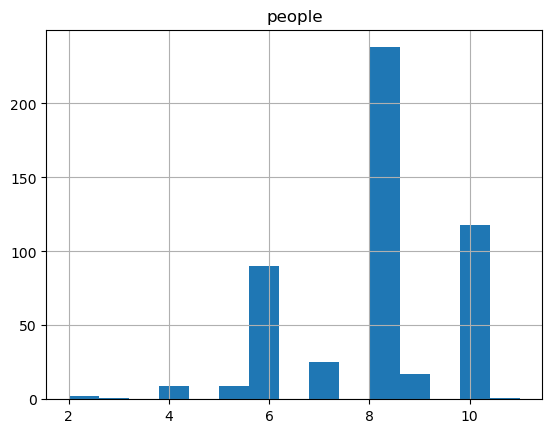

In [70]:
df.hist(column='people', bins=15)

<Axes: xlabel='people', ylabel='price'>

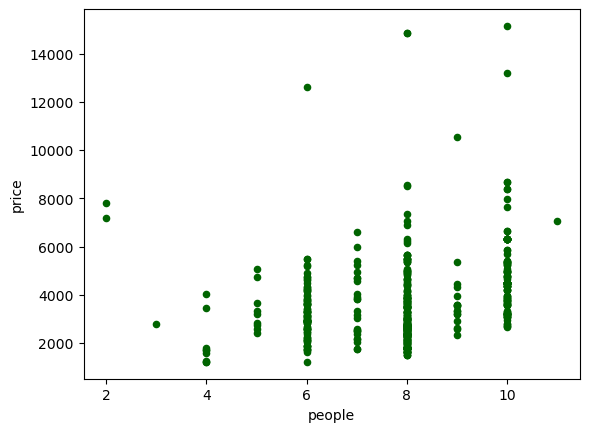

In [72]:
df.plot.scatter(x='people', y='price', c='DarkGreen' )

In [74]:
boat_counts = df['name'].value_counts()

In [76]:
boat_counts

name
Antila 27            42
Twister 26           29
Maxus 33.1 RS        27
Antila 24.4          24
Stillo 30            23
                     ..
Bayliner Ciera        1
Barkas Europa 900     1
Solina 24             1
Tango 780 Sport       1
Balt 1018 Tytan       1
Name: count, Length: 114, dtype: int64

In [158]:
import matplotlib.pyplot as plt

### Top 5 most frequent boats

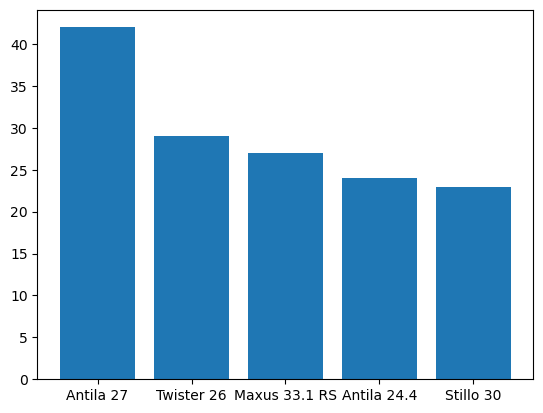

In [163]:
top5=boat_counts[:5]
plt.bar(top5.index, top5.values,  width = 0.8)
plt.show()

### Most expensive boats

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Seamaster 45'),
  Text(1, 0, 'Maestro 42'),
  Text(2, 0, 'Bayliner Ciera'),
  Text(3, 0, 'Merry Fisher 795 S2'),
  Text(4, 0, 'Futura 40'),
  Text(5, 0, 'Nautika 1300'),
  Text(6, 0, 'Beneteau Antares 8')])

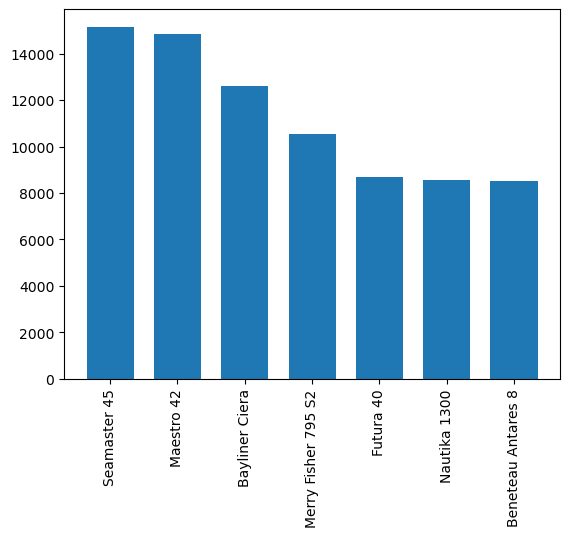

In [166]:
prices_df = df.sort_values(by='price',ascending=False)
prices_df=prices_df.head(10)
plt.bar(prices_df['name'], prices_df['price'],  width = 0.7)
plt.xticks(rotation=90)


# Moje wykresy

#### Niestety wystąpił problem z modłuem title z matplotlib, więc wykresy są podpisane w markdownach.

In [169]:
print(max(df['liczba osób']))

11


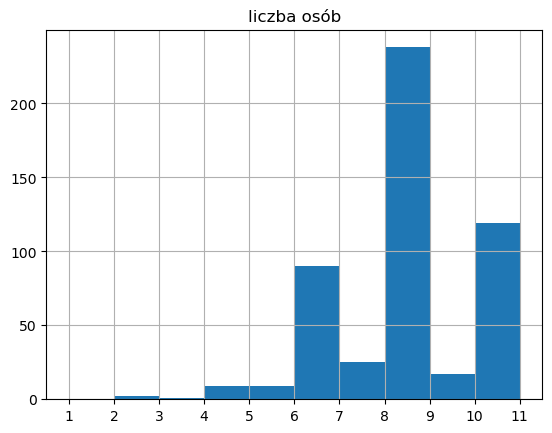

In [171]:
import numpy as np

df.hist(column='liczba osób', bins=np.arange(1, 12, 1))
plt.xticks(np.arange(1, 12, 1))
plt.show()

In [173]:
num_cols = df.select_dtypes(include=['number']).columns

In [175]:
num_cols

Index(['price', 'people', 'cabins', 'liczba osób', 'łazienki', 'kaucja',
       'opłata za sprzątanie/serwis', 'zbiornik paliwa',
       'zbiornik wody pitnej'],
      dtype='object')

### Łodzie o najniższej kaucji

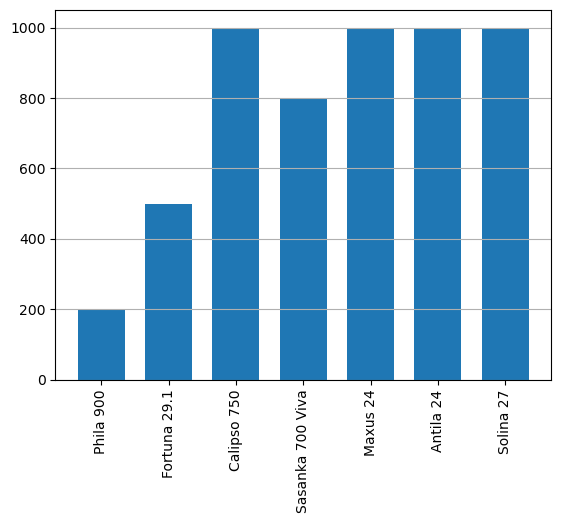

In [179]:
kaucja_df = df.sort_values(by='kaucja',ascending=True)
kaucja_df=kaucja_df.head(10)
plt.bar(kaucja_df['name'], kaucja_df['kaucja'],  width = 0.7)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

In [177]:
print(df["rodzaj paliwa"].unique())


['benzyna' nan 'benzyna (mieszanka z olejem)' 'olej napędowy'
 'energia elektryczna' 'Brak danych']


### Rodzaje paliwa

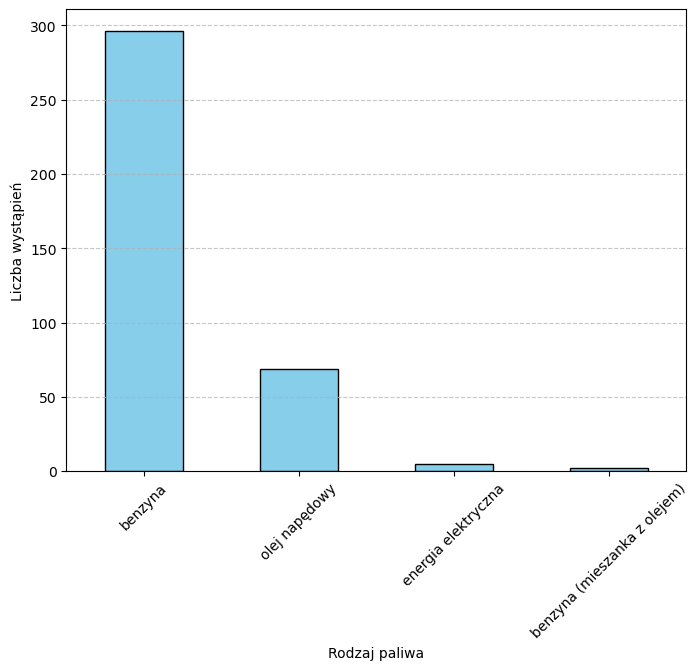

In [189]:
df['rodzaj paliwa'] = df['rodzaj paliwa'].fillna('Brak danych')

df_filtered = df[df['rodzaj paliwa'] != 'Brak danych']

plt.figure(figsize=(8, 6))
df_filtered['rodzaj paliwa'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Rodzaj paliwa')
plt.ylabel('Liczba wystąpień')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
plt.show()

### Łodzie z najwyższą opłatą za serwis/sprzątanie

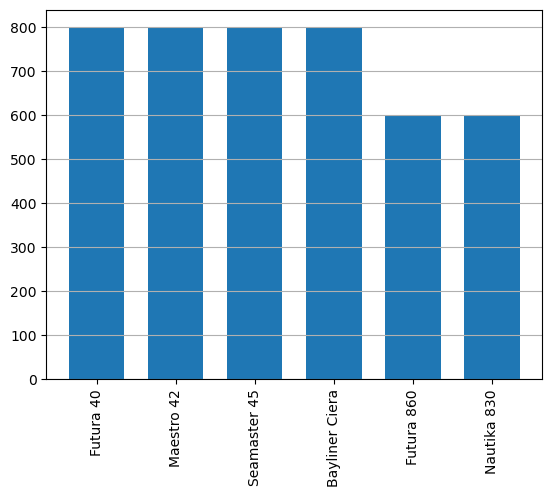

In [199]:
serwis_df = df.sort_values(by='opłata za sprzątanie/serwis',ascending=False)
serwis_df=serwis_df.head(10)
plt.bar(serwis_df['name'], serwis_df['opłata za sprzątanie/serwis'],  width = 0.7)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

### Łodzie z najniższą opłatą za serwis/sprzątanie

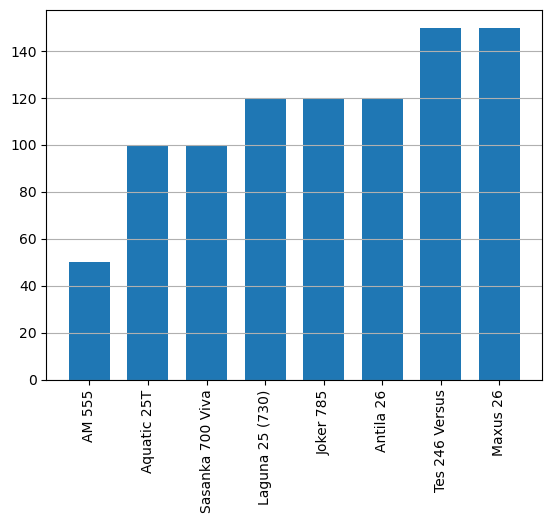

In [201]:
serwis_df = df.sort_values(by='opłata za sprzątanie/serwis',ascending=True)
serwis_df=serwis_df.head(10)
plt.bar(serwis_df['name'], serwis_df['opłata za sprzątanie/serwis'],  width = 0.7)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

In [222]:
print(df.columns)

Index(['name', 'price', 'img', 'url', 'people', 'cabins', 'year',
       'liczba osób', 'liczba koi', 'łazienki', 'rok produkcji', 'uprawnienia',
       'kaucja', 'opłata za sprzątanie/serwis', 'przyjazd', 'wyjazd',
       'długość (cm)', 'szerokość (cm)', 'zanurzenie min (cm)',
       'zanurzenie max (cm)', 'max wysokość w kabinie (cm)',
       'max liczba załogi (bez noclegu)', 'liczba zamykanych kabin (sypialni)',
       'liczba łazienek', 'typ miecza', 'typ steru', 'liczba koi (układ koi)'],
      dtype='object')


### Łodzie o najniższym spalaniu (L/h)

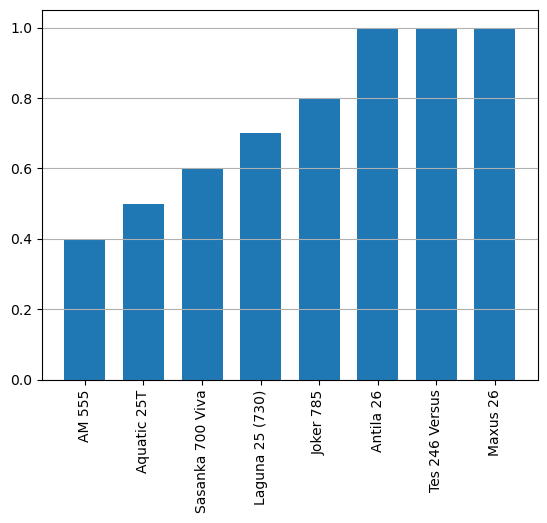

In [231]:
df['przeciętne spalanie'] = pd.to_numeric(df['przeciętne spalanie'], errors='coerce')
spalanie_df = df.sort_values(by='przeciętne spalanie',ascending=True)
spalanie_df=spalanie_df.head(10)
plt.bar(serwis_df['name'], spalanie_df['przeciętne spalanie'],  width = 0.7)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

### Łodzie o najwyższym spalaniu

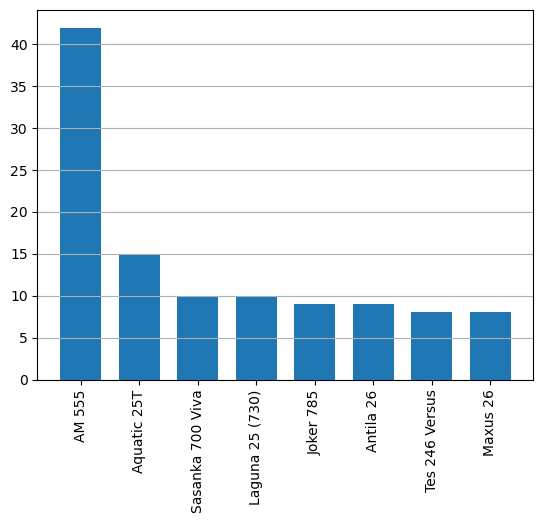

In [240]:
spalanie_df = df.sort_values(by='przeciętne spalanie',ascending=False)
spalanie_df=spalanie_df.head(10)
plt.bar(serwis_df['name'], spalanie_df['przeciętne spalanie'],  width = 0.7)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

array([[<Axes: title={'center': 'przeciętne spalanie'}>]], dtype=object)

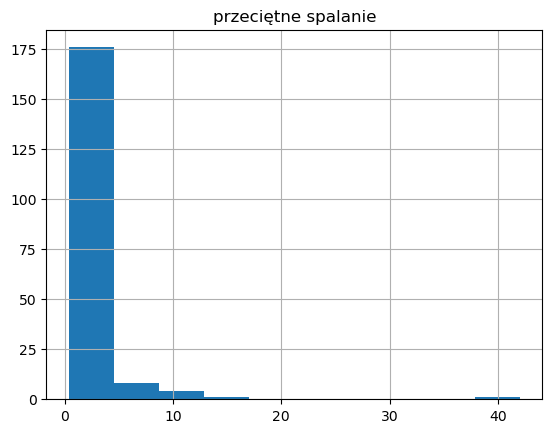

In [242]:
df.hist(column = 'przeciętne spalanie')

array([[<Axes: title={'center': 'moc silnika'}>]], dtype=object)

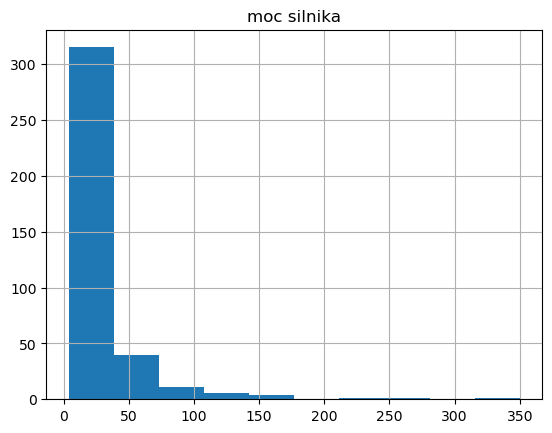

In [244]:
df['moc silnika'] = pd.to_numeric(df['moc silnika'], errors='coerce')
df.hist(column = 'moc silnika')